# Purpose
The purpose of this notebook is two-fold. In it, I aim to:
1. Reproduce the MNL model used in "Brownstone, Davide and Train, Kenneth (1999). 'Forecasting new product penetration with flexible substitution patterns'. Journal of Econometrics 89: 109-129." (p. 121).
2. 'Check' the MNL model for lack-of-fit between observable features of the data and predictions from the model.
3. Produce 7 plots to illustrate the general model-checking procedure.


In [1]:
import sys
from collections import OrderedDict

import scipy.stats
import pandas as pd
import numpy as np

sys.path.insert(0, '/Users/timothyb0912/Documents/pylogit')
import pylogit as pl

sys.path.insert(0, '/Users/timothyb0912/Documents/stat241a/final_project/')
import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load the car data

In [2]:
car_df = pd.read_csv("../data/car_long_format.csv")

# Correct data errors

Note that the data from the R package 'mlogit' does not match the raw data taken from the journal of applied econometrics data archive. There was likely some error when converting from the format of the data in the archive (which is admittedly a strange format) to the data in mlogit.

Basically, 'electric' fuel type and 'methanol' fuel type appear to be switched.

In [3]:
exchange_dict = {'methanol': 'electric',
                 'electric': 'methanol',
                 'cng': 'cng',
                 'gasoline': 'gasoline'}

car_df['fuel_type'] = car_df['fuel_type'].map(exchange_dict)

# Create the necessary variables

In [4]:
car_df.head(6).T

,0,1,2,3,4,5
obs_id,1,1,1,1,1,1
alt_id,1,2,3,4,5,6
choice,1,0,0,0,0,0
college,0,0,0,0,0,0
hsg2,0,0,0,0,0,0
coml5,0,0,0,0,0,0
vehicle_size,3,3,2,2,3,3
acceleration,4,4,6,6,2.5,2.5
price_over_log_income,4.17534,4.17534,4.81771,4.81771,5.13889,5.13889
top_speed,95,95,110,110,140,140


In [5]:
# Create the 'big_enough' variable
car_df['big_enough'] =\
    (car_df['hsg2'] & (car_df['vehicle_size'] == 3)).astype(int)

# Determine the type of car
car_df['sports_utility_vehicle'] =\
    (car_df['body_type'] == 'sportuv').astype(int)

car_df['sports_car'] =\
    (car_df['body_type'] == 'sportcar').astype(int)
    
car_df['station_wagon'] =\
    (car_df['body_type'] == 'stwagon').astype(int)

car_df['truck'] =\
    (car_df['body_type'] == 'truck').astype(int)

car_df['van'] =\
    (car_df['body_type'] == 'van').astype(int)

# Determine the car's fuel type
car_df['electric'] =\
    (car_df['fuel_type'] == 'electric').astype(int)

car_df['compressed_natural_gas'] =\
    (car_df['fuel_type'] == 'cng').astype(int)

car_df['methanol'] =\
    (car_df['fuel_type'] == 'methanol').astype(int)

# Determine if this is an electric vehicle with a small commute
car_df['electric_commute_lte_5mi'] =\
    (car_df['electric'] & car_df['coml5']).astype(int)

# See if this is an electric vehicle for a college educated person
car_df['electric_and_college'] =\
    (car_df['electric'] & car_df['college']).astype(int)

# See if this is a methanol vehicle for a college educated person
car_df['methanol_and_college'] =\
    (car_df['methanol'] & car_df['college']).astype(int)
    
# Scale the range and acceleration variables
car_df['range_over_100'] = car_df['range'] / 100.0
car_df['acceleration_over_10'] = car_df['acceleration'] / 10.0
car_df['top_speed_over_100'] = car_df['top_speed'] / 100.0
car_df['vehicle_size_over_10'] = car_df['vehicle_size'] / 10.0
car_df['tens_of_cents_per_mile'] = car_df['cents_per_mile'] / 10.0


In [6]:
car_df.loc[car_df.choice == 1, 'fuel_type'].value_counts()

methanol    1491
gasoline    1310
cng         1062
electric     791
Name: fuel_type, dtype: int64

In [7]:
# Store a version of the dataset for the mixed logit model in R
neg_variables = ['price_over_log_income',
                 'acceleration_over_10',
                 'pollution',
                 'tens_of_cents_per_mile']

prefix = 'neg_'
for col in neg_variables:
    new_col = prefix + col
    car_df[new_col] = -1 * car_df[col]

car_df.to_csv("../data/mixl_ready_car_data.csv", index=False)

# Create the utility specification

In [8]:
car_mnl_spec, car_mnl_names = OrderedDict(), OrderedDict()

cols_and_display_names =\
    [('price_over_log_income', 'Price over log(income)'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
for col, display_name in cols_and_display_names:
    car_mnl_spec[col] = 'all_same'
    car_mnl_names[col] = display_name


# Estimate the MNL model

In [9]:
# Initialize the mnl model
car_mnl = pl.create_choice_model(data=car_df,
                                 alt_id_col='alt_id',
                                 obs_id_col='obs_id',
                                 choice_col='choice',
                                 specification=car_mnl_spec,
                                 model_type='MNL',
                                 names=car_mnl_names)

# Create the initial variables for model estimation
num_vars = len(car_mnl_names)
initial_vals = np.zeros(num_vars)

# Estimate the mnl model
fit_vals = car_mnl.fit_mle(initial_vals,
                           method='L-BFGS-B',
                           just_point=True)['x']
# Note ridge=1e-7 produces the same results as non-regularized MLE
car_mnl.fit_mle(fit_vals, method='BFGS')

# Look at the estimation results
car_mnl.get_statsmodels_summary()

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,391.8638


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -7,391.8300


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,633
Method:                                MLE   Df Model:                           21
Date:                     Tue, 15 May 2018   Pseudo R-squ.:                   0.114
Time:                             07:05:41   Pseudo R-bar-squ.:               0.111
AIC:                            14,825.660   Log-Likelihood:             -7,391.830
BIC:                            14,961.015   LL-Null:                    -8,338.849
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Price over log(income)          -0.1854      0.027     -6.796      0.000        -0.239    -0.132
Range (units: 100mi)             0.3501      0.027     13.052      0.000         0.298     0.403
Acceleration (units: 0.1sec)    -0.7160      0.111     -6.472      0.000        -0.933    -0.499
Top speed (units: 0.01mph)       0.2612      0.081      3.228      0.001         0.103     0.420
Pollution                       -0.4441      0.102     -4.367      0.000        -0.643    -0.245
Size                             0.9345      0.316      2.953      0.003         0.314     1.555
Big enough                       0.1432      0.077      1.853      0.064        -0.008     0.295
Luggage space                    0.5009      0.191      2.623      0.009         0.127     0.875
Operation cost                  -0.7679      0.076    -10.131      0.000        -0.916    -0.619
Station availability             0.4133      0.096      4.294      0.000         0.225     0.602
Sports utility vehicle           0.8201      0.141      5.830      0.000         0.544     1.096
Sports car                       0.6370      0.148      4.298      0.000         0.347     0.928
Station wagon                   -1.4367      0.062    -23.139      0.000        -1.558    -1.315
Truck                           -1.0168      0.049    -20.753      0.000        -1.113    -0.921
Van                             -0.7989      0.047    -16.864      0.000        -0.892    -0.706
EV                              -0.1786      0.172     -1.041      0.298        -0.515     0.158
Commute < 5 & EV                 0.1983      0.084      2.374      0.018         0.035     0.362
College & EV                     0.4426      0.109      4.058      0.000         0.229     0.656
CNG                              0.3450      0.092      3.744      0.000         0.164     0.526
Methanol                         0.3134      0.103      3.051      0.002         0.112     0.515
College & Methanol               0.2284      0.089      2.576      0.010         0.055     0.402
================================================================================================
"""

In [10]:
print(np.round(pd.concat([car_mnl.params,
                    car_mnl.standard_errors],
                   axis=1),
               decimals=3).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  parameters &  std\_err \\
\midrule
Price over log(income)       &      -0.185 &    0.027 \\
Range (units: 100mi)         &       0.350 &    0.027 \\
Acceleration (units: 0.1sec) &      -0.716 &    0.111 \\
Top speed (units: 0.01mph)   &       0.261 &    0.081 \\
Pollution                    &      -0.444 &    0.102 \\
Size                         &       0.934 &    0.316 \\
Big enough                   &       0.143 &    0.077 \\
Luggage space                &       0.501 &    0.191 \\
Operation cost               &      -0.768 &    0.076 \\
Station availability         &       0.413 &    0.096 \\
Sports utility vehicle       &       0.820 &    0.141 \\
Sports car                   &       0.637 &    0.148 \\
Station wagon                &      -1.437 &    0.062 \\
Truck                        &      -1.017 &    0.049 \\
Van                          &      -0.799 &    0.047 \\
EV                           &      -0.179 &    0.172 \\
Commute < 5 \& EV

# Replication Results

The original modeling results have been replicated. To do so, I needed to change the vehicle fuel types in the mlogit data to correct a likely transcription error.

# MNL Model Checking

In [11]:
# Simulate values from the sampling distribution of coefficients
cov_matrix = np.linalg.inv(-1 * car_mnl.hessian)
mnl_sampling_dist =\
    scipy.stats.multivariate_normal(mean=car_mnl.params.values,
                                    cov=cov_matrix)

In [12]:
# Take Draws from the sampling distribution
num_draws = 1000
np.random.seed(325)
simulated_coefs = mnl_sampling_dist.rvs(num_draws)
simulated_coefs.shape

(1000, 21)

In [13]:
# Predict the model probabilities
simulated_probs =\
    car_mnl.predict(car_df,
                    param_list=[simulated_coefs.T, None, None, None])

# Simulate y from the sampling distribution
likelihood_sim_y =\
    viz.simulate_choice_vector(simulated_probs,
                               car_df['obs_id'].values,
                               rseed=1122018)

Simulating Choices: 100%|██████████| 4654/4654 [00:00<00:00, 5406.52it/s]


# Make the seven desired plots

In [15]:
import seaborn as sbn
import matplotlib.pyplot as plt

### 1. Log-Likelihood plot

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


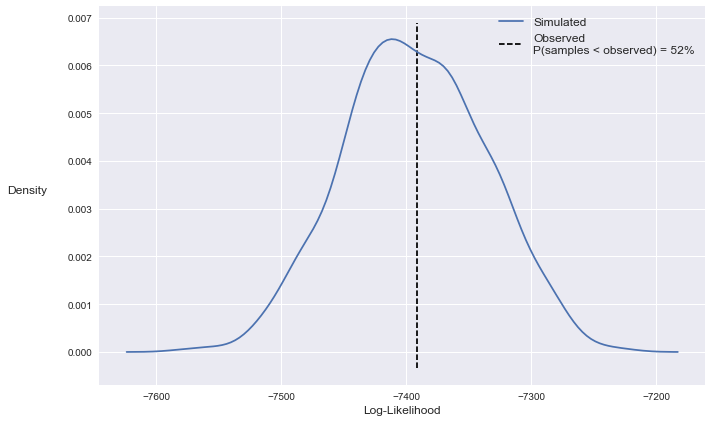

In [15]:
reload(viz)

sim_log_likes =\
    viz.compute_prior_predictive_log_likelihoods(likelihood_sim_y,
                                                 car_df,
                                                 "choices",
                                                 car_mnl)

log_like_path = '../images/log-predictive-vehicle-choice-mnl.pdf'
viz.plot_predicted_log_likelihoods(sim_log_likes,
                                   car_mnl.llf,
                                   output_file=log_like_path)

### 2. Outcome Boxplot

Unique x-values: 100%|██████████| 4/4 [00:00<00:00, 25.65it/s]


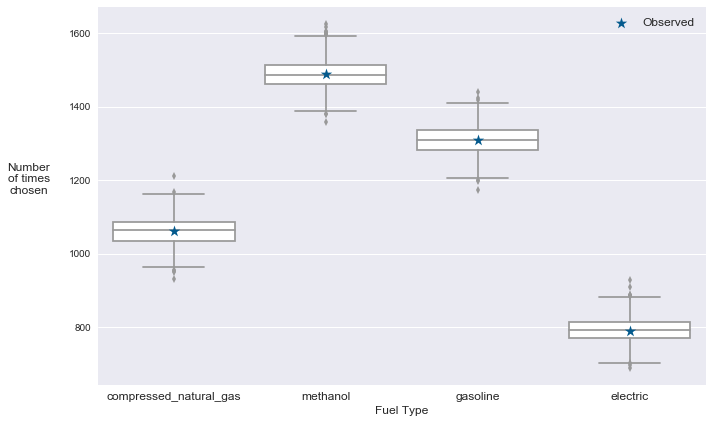

In [16]:
reload(viz)
market_path = '../images/market-share-plot-vehicle-choice-mnl.pdf'

market_dict = dict(cng='compressed_natural_gas')

viz.plot_simulated_market_shares(car_df.fuel_type.values,
                                 likelihood_sim_y,
                                 car_df.choice.values,
                                 x_label='Fuel Type',
                                 y_label='Number\nof times\nchosen',
                                 display_dict=market_dict,
                                 output_file=market_path)

Unique x-values: 100%|██████████| 6/6 [00:00<00:00, 41.69it/s]


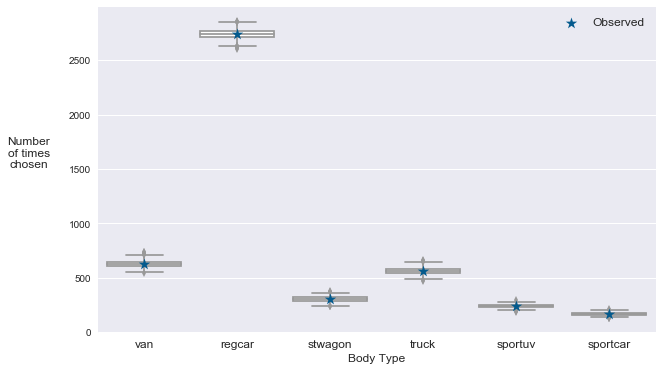

In [17]:
reload(viz)
viz.plot_simulated_market_shares(car_df.body_type.values,
                                 likelihood_sim_y,
                                 car_df.choice.values,
                                 x_label='Body Type',
                                 y_label='Number\nof times\nchosen')

### 3. Binned Reliability Plot

Plotting: 100%|██████████| 1/1 [00:00<00:00, 290.02it/s]


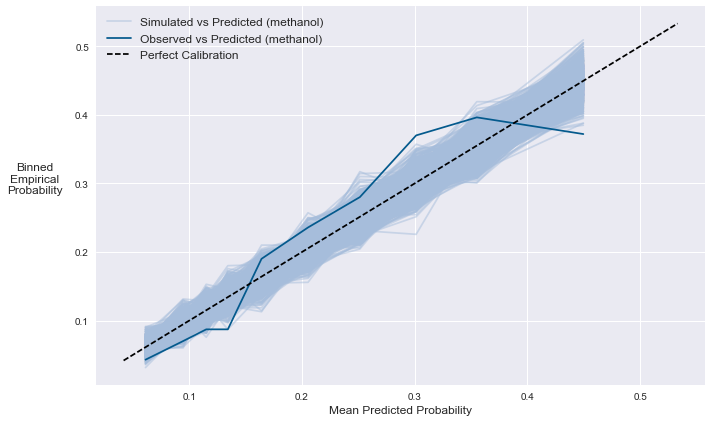

In [19]:
reload(viz)
current_fuel = 'methanol'
filter_idx = np.where((car_df.fuel_type == current_fuel).values)[0]
# current_probs = simulated_probs[filter_idx, :]
current_probs = car_mnl.long_fitted_probs[filter_idx]
current_choices = car_mnl.choices[filter_idx]
current_sim_y = likelihood_sim_y[filter_idx, :]
current_line_label = 'Observed vs Predicted ({})'.format(current_fuel)
current_sim_label = 'Simulated vs Predicted ({})'.format(current_fuel)

current_sim_color = '#a6bddb'
current_obs_color = '#045a8d'

viz.plot_binned_reliability(
    current_probs,
    current_choices,
    sim_y=current_sim_y,
    line_label=current_line_label,
    line_color=current_obs_color,
    sim_label=current_sim_label,
    sim_line_color=current_sim_color,
    figsize=(10, 6),
    ref_line=True,
    output_file='../images/reliability-plot-vehicle-choice-mnl-methanol-point.pdf')

###  4. Binned Marginal Model Plot

Plotting: 100%|██████████| 1000/1000 [00:03<00:00, 265.26it/s]


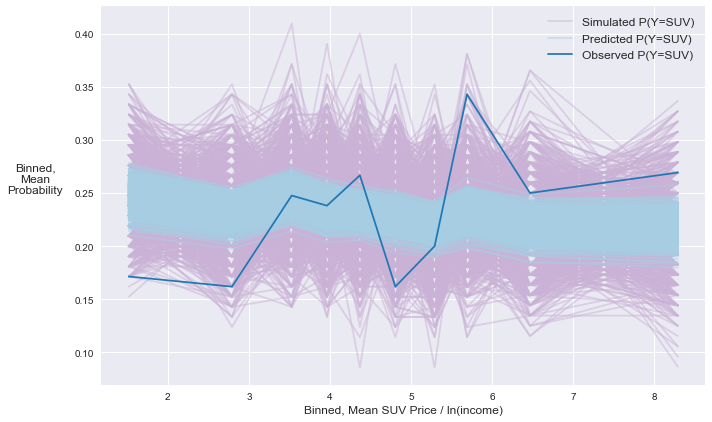

In [20]:
current_body = 'sportuv'
selection_idx = (car_df.body_type == current_body).values

num_traces = 500
current_probs = simulated_probs[selection_idx]
current_y = car_df.loc[selection_idx, 'choice'].values
current_x = car_df.loc[selection_idx, 'price_over_log_income'].values
current_sim_y = likelihood_sim_y[selection_idx]

filename =\
    '../images/marginal-model-plot-vehicle-choice-mnl-suv.pdf'

viz.make_binned_marginal_model_plot(current_probs,
                                    current_y,
                                    current_x,
                                    partitions=10,
                                    sim_y=current_sim_y,
                                    y_label='Observed P(Y=SUV)',
                                    prob_label='Predicted P(Y=SUV)',
                                    sim_label='Simulated P(Y=SUV)',
                                    x_label='Binned, Mean SUV Price / ln(income)',
                                    alpha=0.5,
                                    figsize=(10, 6),
                                    output_file=filename)

### 5. Simulated Histogram

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


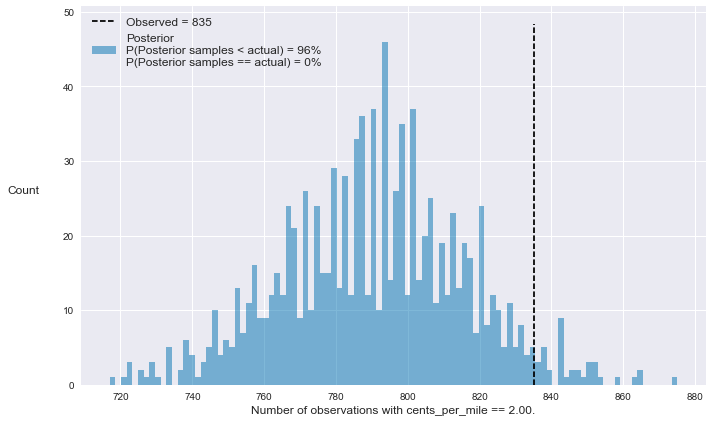

In [16]:
reload(viz)

filter_row = ((car_df.body_type == 'regcar') &
              (car_df.cents_per_mile == 2))
# current_title = 'Num Observations by Cents per Mile for Body = {}'
current_title = ''
filename =\
    '../images/histogram-vehicle-choice-mnl-regcar-operating-costs.pdf'

viz.plot_categorical_predictive_densities(
    car_df,
    None,
    likelihood_sim_y,
    'cents_per_mile',
    filter_row,
    car_mnl.choices,
    title=current_title.format('Regular Car'),
    filter_name='observations',
    post_color=sbn.color_palette('colorblind')[0],
    figsize=(10, 6),
    legend_loc='upper left',
    output_file=filename)

### 6. Simulated KDE

Calculating KDEs: 100%|██████████| 500/500 [00:02<00:00, 210.75it/s]


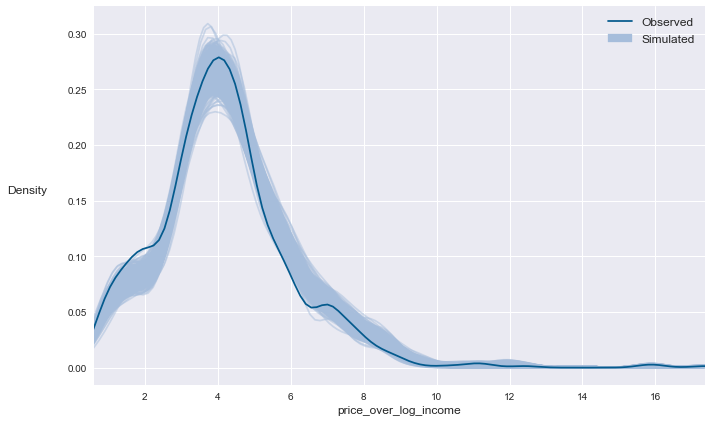

In [17]:
reload(viz)
current_fuel = 'electric'
filter_row = car_df.fuel_type == current_fuel
# current_title = 'KDE of Price/log(income) for {} vehicles'
current_title = ''
filename =\
    '../images/kde-vehicle-choice-mnl-electric-price.pdf'

viz.plot_simulated_kde_traces(likelihood_sim_y,
                              car_df,
                              filter_row,
                              'price_over_log_income',
                              'choice',
                              title=current_title.format(current_fuel),
                              figsize=(10, 6),
                              label='Simulated',
                              n_traces=500,
                              output_file=filename)

### 7. Simulated CDF

Calculating CDFs: 100%|██████████| 1000/1000 [00:04<00:00, 243.57it/s]


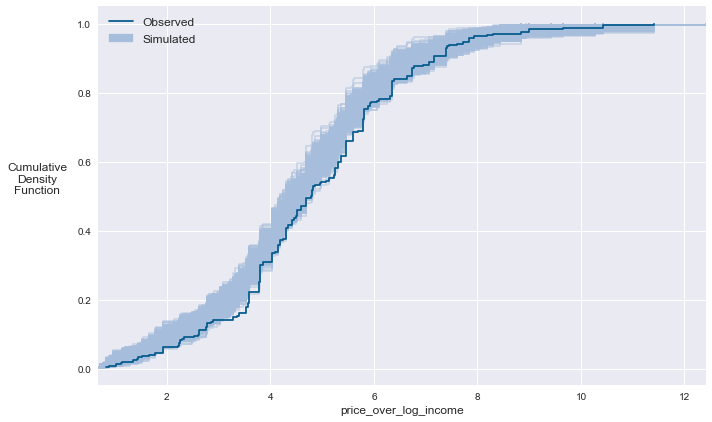

In [29]:
reload(viz)
current_body = 'sportuv'
filter_row = car_df.body_type == current_body
# current_title =\
#     'CDF of Price/log(income) for Sport Utility Vehicles'
current_title = ''
filename =\
    '../images/cdf-vehicle-choice-mnl-suv-price.pdf'

viz.plot_simulated_cdf_traces(likelihood_sim_y,
                              car_df,
                              filter_row,
                              'price_over_log_income',
                              'choice',
                              label='Simulated',
                              title=current_title,
                              figsize=(10, 6),
                              output_file=filename)

## Sandbox:
Look at additional plots.

Plotting: 100%|██████████| 1000/1000 [00:03<00:00, 266.07it/s]


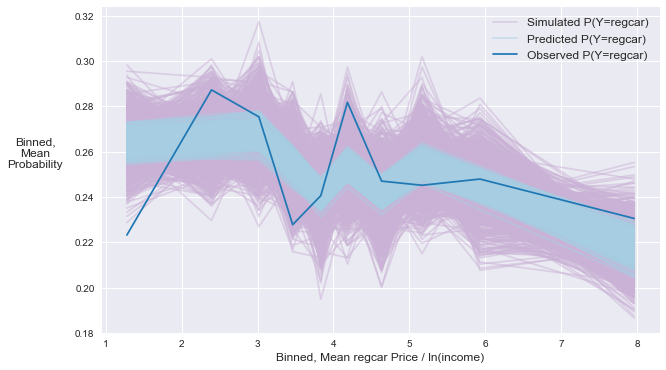

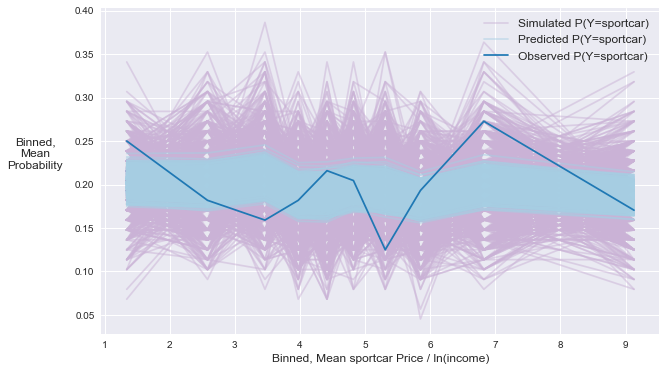

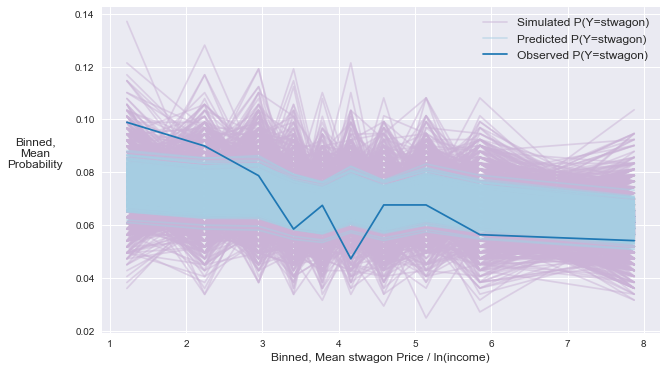

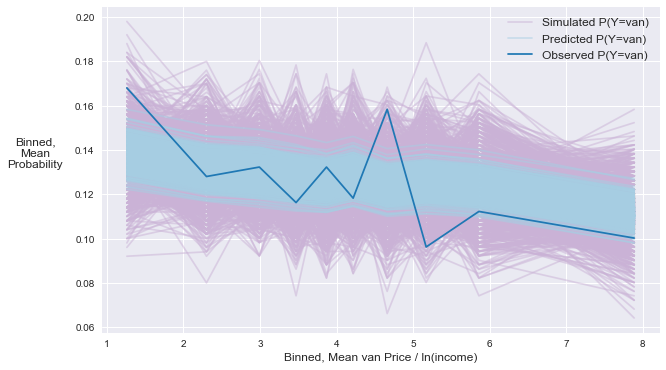

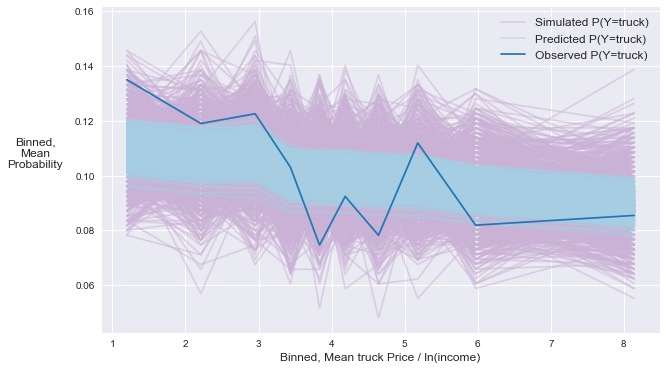

In [24]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    current_body = body
    selection_idx = (car_df.body_type == current_body).values

    num_traces = 500
    current_probs = simulated_probs[selection_idx]
    current_y = car_df.loc[selection_idx, 'choice'].values
    current_x = car_df.loc[selection_idx, 'price_over_log_income'].values
    current_sim_y = likelihood_sim_y[selection_idx]

    filename = None

    viz.make_binned_marginal_model_plot(current_probs,
                                        current_y,
                                        current_x,
                                        partitions=10,
                                        sim_y=current_sim_y,
                                        y_label='Observed P(Y={})'.format(body),
                                        prob_label='Predicted P(Y={})'.format(body),
                                        sim_label='Simulated P(Y={})'.format(body),
                                        x_label='Binned, Mean {} Price / ln(income)'.format(body),
                                        alpha=0.5,
                                        figsize=(10, 6),
                                        output_file=filename)

Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 257.91it/s]


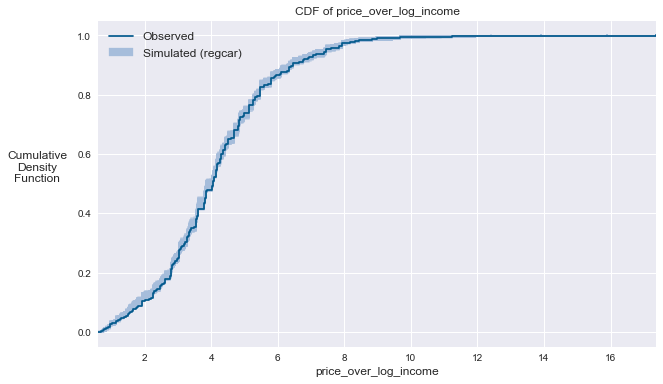

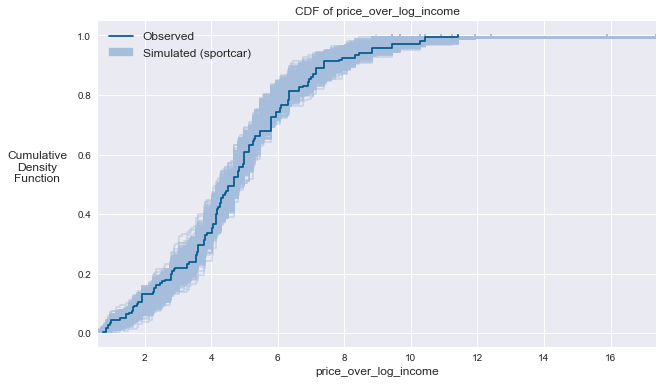

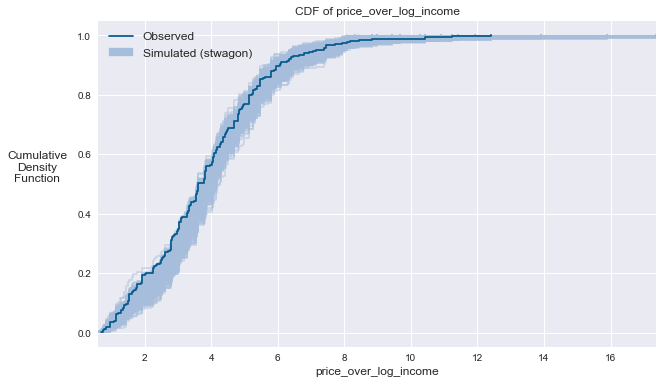

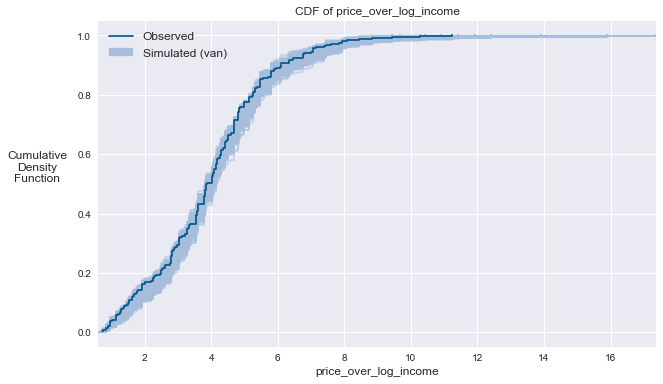

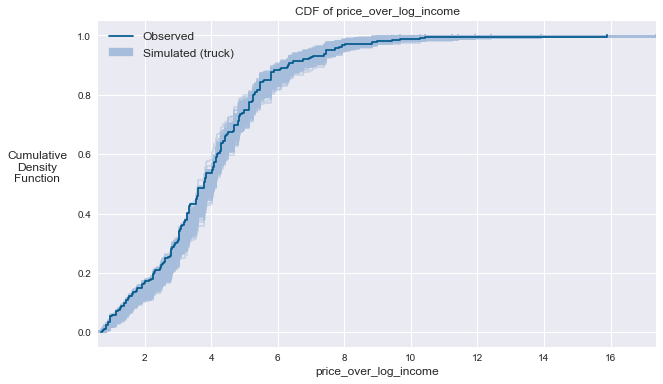

In [25]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    current_body = body
    filter_row = car_df.body_type == current_body
    # current_title =\
    #     'CDF of Price/log(income) for Sport Utility Vehicles'
    current_title = ''
    filename = None
    viz.plot_simulated_cdf_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  label='Simulated ({})'.format(body),
                                  title=current_title,
                                  figsize=(10, 6),
                                  output_file=filename)

Plotting: 100%|██████████| 1/1 [00:00<00:00, 251.19it/s]


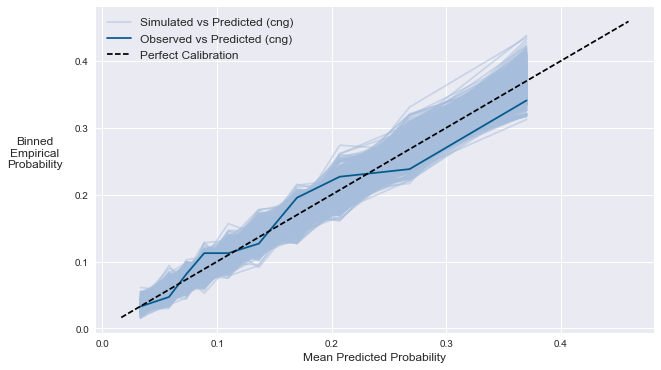

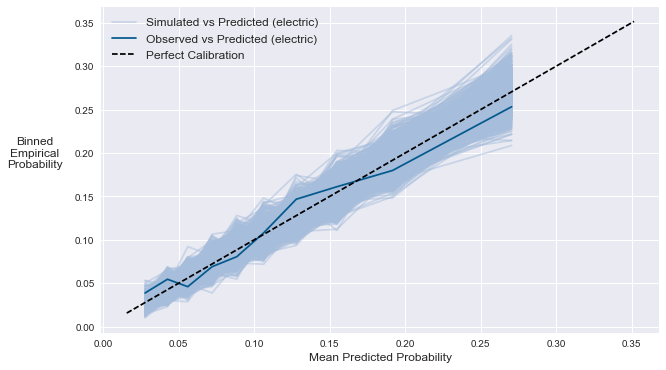

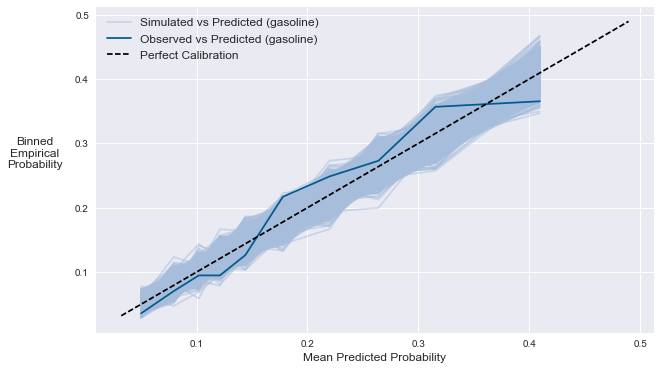

In [32]:
for fuel in ['cng', 'electric', 'gasoline']:
    reload(viz)
    current_fuel = fuel
    filter_idx = np.where((car_df.fuel_type == current_fuel).values)[0]
    # current_probs = simulated_probs[filter_idx, :]
    current_probs = car_mnl.long_fitted_probs[filter_idx]
    current_choices = car_mnl.choices[filter_idx]
    current_sim_y = likelihood_sim_y[filter_idx, :]
    current_line_label = 'Observed vs Predicted ({})'.format(current_fuel)
    current_sim_label = 'Simulated vs Predicted ({})'.format(current_fuel)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    reliability_path = None
    viz.plot_binned_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=reliability_path)